In [ ]:
#Importing necessary parameters
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


In [ ]:

#Setting up the device agnoistic code
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#Creating the necessary transforms.

mean=np.array([0.485, 0.456, 0.406])
std= np.array([0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [ ]:

#Importing the data
train_data= torchvision.datasets.STL10(root='data',
                                       split= "train",
                                       download=True,
                                       transform=train_transform)
test_data= torchvision.datasets.STL10(root='data',
                                      split='test',
                                       download=True,
                                       transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_data), len(test_data)

(5000, 8000)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader= DataLoader(dataset= train_data, batch_size=100, shuffle=True)
test_dataloader= DataLoader(dataset= test_data, batch_size=100, shuffle=True)

In [ ]:
model_0= models.resnet18(pretrained=True)
for param in model_0.parameters():
  param.requires_grad=False
num_feat= model_0.fc.in_features
model_0.fc = nn.Linear(num_feat, 10) #assigning no of output classes to the last FC layer.
model_0.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion= nn.CrossEntropyLoss()


In [ ]:
#Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item()
  acc= (correct/len(y_pred)) * 100
  return acc 

In [ ]:
test_loss_list=[]
test_acc_list=[]
def test(model):
  test_loss = 0
  test_acc = 0
  #model.eval()
  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      X,y = X.to(device),y.to(device)
      test_pred= model(X)
      test_loss += criterion(test_pred,y).item()
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))
    
  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)
  print(f"Test loss :{test_loss:.4f} | test accuraacy: {test_acc:.4f}")
   

In [ ]:
train_loss_list = []
def train(model,epochs):
  for epoch in range(epochs):
    print(f"Epoch:{epoch}  \n-------")

    train_loss = 0
    train_acc = 0
    for batch, (X,y) in enumerate(train_dataloader):
      X,y = X.to(device),y.to(device)
      model.train()
      y_pred=model(X)
      train_acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))
      loss= criterion(y_pred,y)
      optimizer.zero_grad()
      train_loss += loss.item()
      loss.backward()
      optimizer.step()

      if batch%10==0:
        # print(batch)
        
        print(f"Looked at {batch*len(X)}/ {len(train_dataloader.dataset)} samples.")
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_list.append(train_loss)
    print(f"Train loss :{train_loss:.4f}| train accuraacy: {train_acc:.4f}")
    test(model_0)

In [ ]:
model_0.to(device)
optimizer = optim.SGD(model_0.parameters(), lr=1e-1)
#model= train(model_0, epochs=2)
train(model_0,10)


In [ ]:
#RMS PROP ALGORITHM
model_0.to(device)
optimizer = optim.RMSprop(model_0.parameters(), lr=1e-1, alpha=0.8)
#model= train(model_0, epochs=2)
train(model_0,10)

Epoch:0  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :19.9190| train accuraacy: 48.9400
Test loss :10.3339 | test accuraacy: 64.2750
Epoch:1  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :9.0294| train accuraacy: 66.0200
Test loss :7.8464 | test accuraacy: 69.7125
Epoch:2  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :8.1795| train accuraacy: 69.4600
Test loss :8.5009 | test accuraacy: 70.2375
Epoch:3  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :7.6612| train accuraacy: 72.2000
Test loss :16.8188 | test 

In [ ]:
epoch_list= [i for i in range(10)]
print(train_loss_list)
print(test_loss_list)
epoch_list

[19.91899401664734, 9.029361896514892, 8.179548225402833, 7.66123113155365, 6.8787445545196535, 6.605893681049347, 6.474802606105804, 6.444143242835999, 6.451693015098572, 6.004986066818237]
[10.333891904354095, 7.846403366327285, 8.500868904590607, 16.81876858472824, 11.136294209957123, 9.499908682703971, 9.039731886982917, 16.065402603149415, 12.673370152711868, 11.37254444360733]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

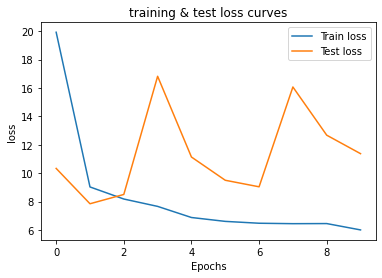

In [ ]:
import numpy as np

#plot loss curves
plt.plot(epoch_list, train_loss_list, label ='Train loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.title("training & test loss curves")
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.legend();


In [ ]:
#ADAM ALGORITHM
model = model_0.to(device)
model_0.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9,0.999))
#model= train(model_0, epochs=2)
train(model_0,10)

Epoch:0  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :1.4826| train accuraacy: 52.4000
Test loss :0.9500 | test accuraacy: 72.5500
Epoch:1  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.8104| train accuraacy: 75.3800
Test loss :0.7791 | test accuraacy: 75.2750
Epoch:2  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.6625| train accuraacy: 79.3400
Test loss :0.7105 | test accuraacy: 77.1750
Epoch:3  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.6077| train accuraacy: 80.8800
Test loss :0.6827 | test acc

In [ ]:
epoch_list= [i for i in range(10)]
print(train_loss_list)
print(len(train_loss_list))
print(test_loss_list)
print(len(test_loss_list))
epoch_list

[19.91899401664734, 9.029361896514892, 8.179548225402833, 7.66123113155365, 6.8787445545196535, 6.605893681049347, 6.474802606105804, 6.444143242835999, 6.451693015098572, 6.004986066818237, 1.4825629091262817, 0.8103891241550446, 0.662513736486435, 0.6076727437973023, 0.5604900425672531, 0.5285708826780319, 0.5026353257894516, 0.4785805892944336, 0.46178874671459197, 0.45203172624111176]
20
[0.9499919280409813, 0.779087309539318, 0.7105268515646458, 0.6826978843659163, 0.6572248406708241, 0.6623850751668214, 0.6350833125412464, 0.6269537501037121, 0.6225449699908495, 0.6253866273909807]
10


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

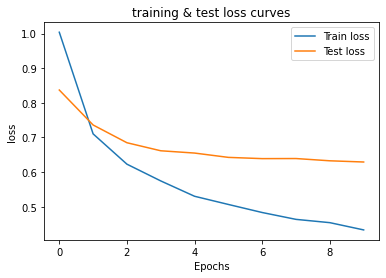

In [ ]:
import numpy as np

#plot loss curves
plt.plot(epoch_list, train_loss_list, label ='Train loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.title("training & test loss curves")
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.legend();


In [ ]:
#ADAM ALGORITHM
model_0.to(device)
optimizer = optim.Adam(model_0.parameters(), lr=1e-2, betas=(0.5,0.999))
train(model_0,10)


Epoch:0  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :1.1656| train accuraacy: 64.6600
Test loss :0.7000 | test accuraacy: 77.0375
Epoch:1  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.5722| train accuraacy: 80.4800
Test loss :0.6992 | test accuraacy: 77.2000
Epoch:2  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.5191| train accuraacy: 82.0800
Test loss :0.8261 | test accuraacy: 74.4500
Epoch:3  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.5013| train accuraacy: 83.0400
Test loss :0.7862 | test acc

In [ ]:
epoch_list= [i for i in range(10)]
print(train_loss_list)
print(test_loss_list)
epoch_list

[1.165573272705078, 0.5721875578165054, 0.5190924900770187, 0.501261225938797, 0.48163175404071806, 0.41897727698087694, 0.44606784522533416, 0.40547110050916674, 0.43624212116003036, 0.4395543172955513]
[0.7000253893435001, 0.6991940580308438, 0.8260715182870626, 0.7861758001148701, 0.8248756252229213, 0.8198846854269505, 0.7696033153682947, 0.8426219008862972, 0.9839148238301277, 0.9293356209993362]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

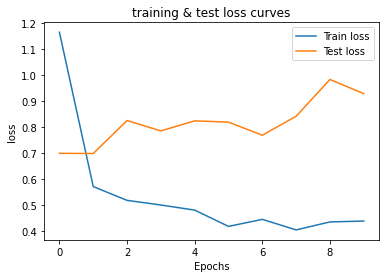

In [ ]:
import numpy as np

#plot loss curves
plt.plot(epoch_list, train_loss_list, label ='Train loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.title("training & test loss curves")
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.legend();


In [ ]:
#ADAGRAD ALGORITHM
model_0.to(device)
optimizer = optim.Adagrad(model_0.parameters(), lr=1e-1, weight_decay=0.001,eps=1e-10)
#model= train(model_0, epochs=2)
train(model_0,10)


Epoch:0  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :4.2933| train accuraacy: 62.8200
Test loss :1.8256 | test accuraacy: 66.3000
Epoch:1  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.9345| train accuraacy: 77.3800
Test loss :0.9823 | test accuraacy: 75.6500
Epoch:2  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.7498| train accuraacy: 78.9000
Test loss :1.0590 | test accuraacy: 74.5250
Epoch:3  
-------
Looked at 0/ 5000 samples.
Looked at 1000/ 5000 samples.
Looked at 2000/ 5000 samples.
Looked at 3000/ 5000 samples.
Looked at 4000/ 5000 samples.
Train loss :0.6028| train accuraacy: 81.9600
Test loss :0.8805 | test acc

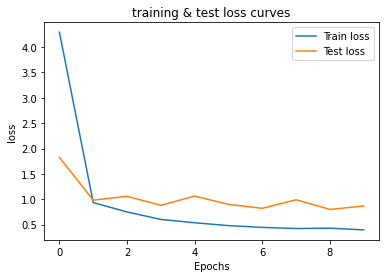

In [ ]:
import numpy as np

#plot loss curves
plt.plot(epoch_list, train_loss_list, label ='Train loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.title("training & test loss curves")
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.legend();
